In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import json

In [11]:
def extract_data(log_dir: str) -> list[dict]:
    data = []

    for exp_dir in (f.path for f in os.scandir(log_dir) if f.is_dir()):
        params = [
            (x.split("=")[0], x.split("=")[1])
            for x in re.findall(r"[a-z]+=[a-zA-Z0-9\.-]+", exp_dir)
        ]
        params[7] = ("lrate", params[7][1])
        params = {x[0]: x[1] for x in params}

        model_results = {}
        for res_dir in (f.path for f in os.scandir(exp_dir) if f.is_dir()):
            with open(res_dir + "/evaluation_results.jsonl") as f:
                results = json.load(f)
                model_results[os.path.basename(res_dir)] = results

        joined = {**params, **model_results}
        data.append(joined)

    return data


In [12]:
base_scores = {
    "aggregate": 0.1698713383658548,
    "mia": 0.0,
    "mmlu": 0.5096140150975644,
    "harmonic": 0.0,
}
base_scores

{'aggregate': 0.1698713383658548,
 'mia': 0.0,
 'mmlu': 0.5096140150975644,
 'harmonic': 0.0}

In [13]:
def collect_scores(data, params: list[str] = ["rm", "km"]):
    checkpoints = list(
        {key for d in data for key in d if key.startswith("checkpoint_")}
    )

    scores = {}

    for d in data:
        p = tuple([d[param] for param in params])
        if p not in scores:
            scores[p] = {}

        for checkpoint in checkpoints:
            if checkpoint not in d:
                continue
            if checkpoint not in scores[p]:
                scores[p][checkpoint] = {
                    "aggregate": [],
                    "harmonic": [],
                    "mia": [],
                    "mmlu": [],
                }
            scores[p][checkpoint]["aggregate"].append(d[checkpoint]["aggregate-score"])
            scores[p][checkpoint]["harmonic"].append(
                d[checkpoint]["harmonic-mean-task-aggregate"]
            )
            scores[p][checkpoint]["mia"].append(d[checkpoint]["mia_final_score"])
            scores[p][checkpoint]["mmlu"].append(d[checkpoint]["mmlu_average"])

    return scores, checkpoints


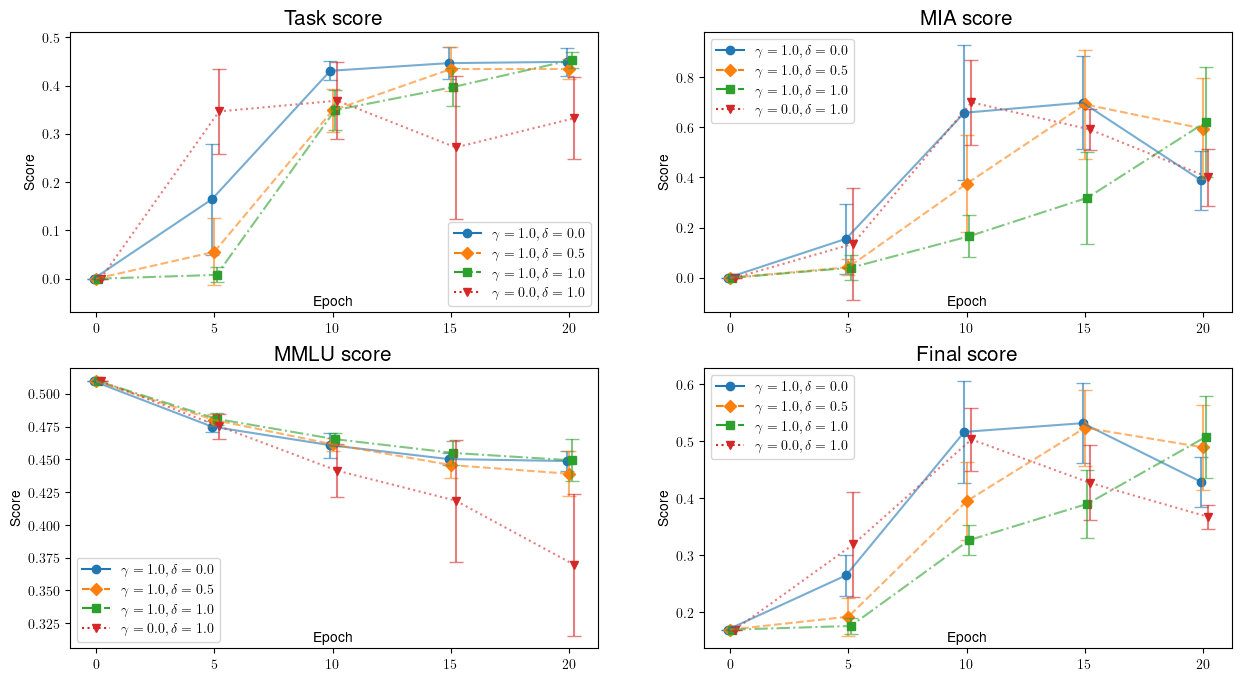

In [14]:
logsdir = "experiment_logs/7B_logs"
data = extract_data(logsdir)
scores, checkpoints = collect_scores(data, params=["rm", "km"])

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

fig, axs = plt.subplots(2, 2, figsize=(15, 8))


points = [
    (5, "checkpoint_4"),
    (10, "checkpoint_9"),
    (15, "checkpoint_14"),
    (20, "checkpoint_19"),
]
measures = ["harmonic", "mia", "mmlu", "aggregate"]
titles = ["Task score", "MIA score", "MMLU score", "Final score"]
idx = [(0, 0), (0, 1), (1, 0), (1, 1)]
offsets = [-0.1, 0, 0.1, 0.2]
markers = ["o", "D", "s", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
linestyles = ["-", "--", "-.", ":"]
markersize = 6
linewidth = 1.5

for i, m in enumerate(measures):
    handles = []
    for j, p in enumerate(scores):
        means = []
        stds = []
        for point in points:
            mean = np.mean(scores[p][point[1]][m])
            std = np.std(scores[p][point[1]][m])
            means.append(mean)
            stds.append(std)
        axs[idx[i]].errorbar(
            [offsets[j]] + [x[0] + offsets[j] for x in points],
            [base_scores[m]] + list(means),
            yerr=[0] + list(stds),
            label=f"$\\gamma$={p[0]}, $\\delta$={p[1]}",
            alpha=0.6,
            color=colors[j],
            linestyle=linestyles[j],
            linewidth=linewidth,
            capsize=5,
        )
        axs[idx[i]].plot(
            [offsets[j]] + [x[0] + offsets[j] for x in points],
            [base_scores[m]] + list(means),
            marker=markers[j],
            linestyle="None",
            color=colors[j],
            markersize=markersize,
        )
        (legend_handle,) = axs[idx[i]].plot(
            [],
            [],
            marker=markers[j],
            label=f"$\\gamma={p[0]}, \\delta={p[1]}$",
            color=colors[j],
            linestyle=linestyles[j],
            linewidth=linewidth,
        )
        handles.append(legend_handle)
    axs[idx[i]].set_title(titles[i], fontsize=15)
    axs[idx[i]].set_xticks([0] + [x[0] for x in points])
    axs[idx[i]].set_xlabel("Epoch")
    axs[idx[i]].xaxis.set_label_coords(0.5, 0.06)
    axs[idx[i]].set_ylabel("Score")
    axs[idx[i]].legend(handles=handles)

axs[(0, 0)].set_ylim(-0.07, 0.51)
plt.savefig("scores.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
# as latex table
chosen_models = ["checkpoint_9", "checkpoint_19"]

for p in scores:
    for model in chosen_models:
        print(f"$\\gamma={p[0][0]}, \\delta={float(p[1]):0.1f}$ {model} ", end="")
        for m in measures:
            mean = np.mean(scores[p][model][m])
            std = np.std(scores[p][model][m])
            print(f"& {mean:0.3f} & $\\pm {std:0.3f}$ ", end="")
        print("\\\\")

$\gamma=1, \delta=0.0$ checkpoint_9 & 0.431 & $\pm 0.020$ & 0.657 & $\pm 0.269$ & 0.461 & $\pm 0.010$ & 0.516 & $\pm 0.089$ \\
$\gamma=1, \delta=0.0$ checkpoint_19 & 0.449 & $\pm 0.029$ & 0.389 & $\pm 0.117$ & 0.449 & $\pm 0.008$ & 0.429 & $\pm 0.043$ \\
$\gamma=1, \delta=0.5$ checkpoint_9 & 0.349 & $\pm 0.045$ & 0.375 & $\pm 0.193$ & 0.462 & $\pm 0.005$ & 0.395 & $\pm 0.069$ \\
$\gamma=1, \delta=0.5$ checkpoint_19 & 0.434 & $\pm 0.021$ & 0.594 & $\pm 0.201$ & 0.439 & $\pm 0.017$ & 0.489 & $\pm 0.074$ \\
$\gamma=1, \delta=1.0$ checkpoint_9 & 0.349 & $\pm 0.041$ & 0.165 & $\pm 0.083$ & 0.465 & $\pm 0.005$ & 0.327 & $\pm 0.027$ \\
$\gamma=1, \delta=1.0$ checkpoint_19 & 0.453 & $\pm 0.016$ & 0.620 & $\pm 0.219$ & 0.449 & $\pm 0.016$ & 0.507 & $\pm 0.072$ \\
$\gamma=0, \delta=1.0$ checkpoint_9 & 0.369 & $\pm 0.080$ & 0.699 & $\pm 0.170$ & 0.441 & $\pm 0.020$ & 0.503 & $\pm 0.056$ \\
$\gamma=0, \delta=1.0$ checkpoint_19 & 0.332 & $\pm 0.085$ & 0.400 & $\pm 0.113$ & 0.370 & $\pm 0.054$ & 0.3

In [16]:
def tabularize(
    log_dir: str,
    checkpoint="checkpoint_19",
    params=["rm", "km"],
    measures=["harmonic", "mia", "mmlu", "aggregate"],
    sorting_fn=None,
    param_format_fn=lambda x: f"{float(x):0.1f}",
    measure_format_fn=lambda x: f"{x:0.3f}"[1:],
):
    data = extract_data(log_dir)
    scores, checkpoints = collect_scores(data, params)

    sorted_params = scores
    if sorting_fn is not None:
        sorted_params = sorting_fn(scores)

    best_ms = {
        m: max(np.mean(scores[p][checkpoint][m]) for p in sorted_params)
        for m in measures
    }

    for p in sorted_params:
        print(f"{param_format_fn(p[0])} & {param_format_fn(p[1])} ", end="")
        for m in measures:
            mean = np.mean(scores[p][checkpoint][m])
            std = np.std(scores[p][checkpoint][m])

            mean_text = measure_format_fn(mean)
            if mean == best_ms[m]:
                mean_text = "\\tb{" + mean_text + "}"

            print(f"& {mean_text} & \\s {measure_format_fn(std)} ", end="")
        print("\\\\")

In [17]:
# 1B hyperparam search
def group_fn(scores):
    group1 = sorted(s for s in scores if s[1] == "0.0")
    group2 = sorted(s for s in scores if s[0] == "0.0")
    group3 = sorted(s for s in scores if s[0] != "0.0" and s[1] != "0.0")
    sorted_params = group1 + group2 + group3
    return sorted_params


tabularize("experiment_logs/1B_logs/", sorting_fn=group_fn)


0.5 & 0.0 & .387 & \s .033 & .322 & \s .047 & .258 & \s .008 & .323 & \s .022 \\
1.0 & 0.0 & .398 & \s .041 & .540 & \s .054 & .265 & \s .005 & .401 & \s .029 \\
2.0 & 0.0 & .423 & \s .056 & .317 & \s .167 & \tb{.270} & \s .003 & .337 & \s .049 \\
0.0 & 0.5 & .269 & \s .086 & .285 & \s .033 & .256 & \s .006 & .270 & \s .035 \\
0.0 & 1.0 & .245 & \s .066 & .516 & \s .074 & .262 & \s .006 & .341 & \s .040 \\
0.0 & 2.0 & .299 & \s .059 & .599 & \s .141 & .269 & \s .004 & .389 & \s .050 \\
0.0 & 5.0 & .362 & \s .065 & .039 & \s .049 & .267 & \s .007 & .222 & \s .021 \\
0.2 & 0.2 & .379 & \s .030 & .295 & \s .056 & .256 & \s .011 & .310 & \s .019 \\
0.5 & 0.5 & .350 & \s .066 & .464 & \s .104 & .268 & \s .006 & .361 & \s .048 \\
0.5 & 1.0 & .442 & \s .030 & .719 & \s .056 & .261 & \s .009 & .474 & \s .025 \\
1.0 & 0.5 & .394 & \s .036 & \tb{.821} & \s .117 & .266 & \s .006 & \tb{.494} & \s .038 \\
1.0 & 1.0 & .419 & \s .061 & .721 & \s .198 & .270 & \s .004 & .470 & \s .084 \\
1.0 & 2.0 & .

In [18]:
def sorted_rank_fn(scores):
    return sorted((s for s in scores), key=lambda x: float(x[0]))

tabularize(
    "experiment_logs/1B_rank_logs",
    params=["lr", "la"],
    sorting_fn=sorted_rank_fn,
    param_format_fn=lambda x: f"{int(float(x))}",
)

1 & 5 & .435 & \s .053 & .743 & \s .107 & .266 & \s .005 & .481 & \s .047 \\
2 & 5 & \tb{.455} & \s .033 & \tb{.895} & \s .127 & .266 & \s .005 & \tb{.539} & \s .039 \\
5 & 5 & .417 & \s .059 & .765 & \s .097 & \tb{.272} & \s .005 & .485 & \s .041 \\
10 & 5 & .372 & \s .037 & .835 & \s .058 & .269 & \s .008 & .492 & \s .025 \\
25 & 5 & .417 & \s .030 & .713 & \s .227 & .265 & \s .006 & .465 & \s .075 \\
100 & 5 & .432 & \s .042 & .658 & \s .282 & .271 & \s .006 & .454 & \s .096 \\


{('1', '5.0'): {'checkpoint_15': {'aggregate': [0.37614369669081327, 0.5142341351779449, 0.533527183491625, 0.4966810702311888, 0.5008532900567086], 'harmonic': [0.3921738047854437, 0.4445103531196486, 0.3925753595239181, 0.4645950472473967, 0.410866075364068], 'mia': [0.47439999999999993, 0.8384, 0.9354666666666668, 0.7515555555555558, 0.8261333333333332], 'mmlu': [0.26185728528699614, 0.259792052414186, 0.27253952428429, 0.27389260789061387, 0.26556046147272466]}, 'checkpoint_3': {'aggregate': [0.14040746890621172, 0.18729152537547208, 0.1676380004794137, 0.16215588540871365, 0.15062886191485877], 'harmonic': [0.15900904679839586, 0.29026084588855844, 0.23286699958665308, 0.2117916841423922, 0.1757863151278551], 'mia': [0.0, 0.0, 0.0, 0.0, 0.0], 'mmlu': [0.2622133599202393, 0.27161373023785784, 0.2700470018515881, 0.2746759720837488, 0.27610027061672127]}, 'checkpoint_1': {'aggregate': [0.09072781655034895, 0.08821155580876418, 0.09155865736124959, 0.0930779091297536, 0.0935526753074

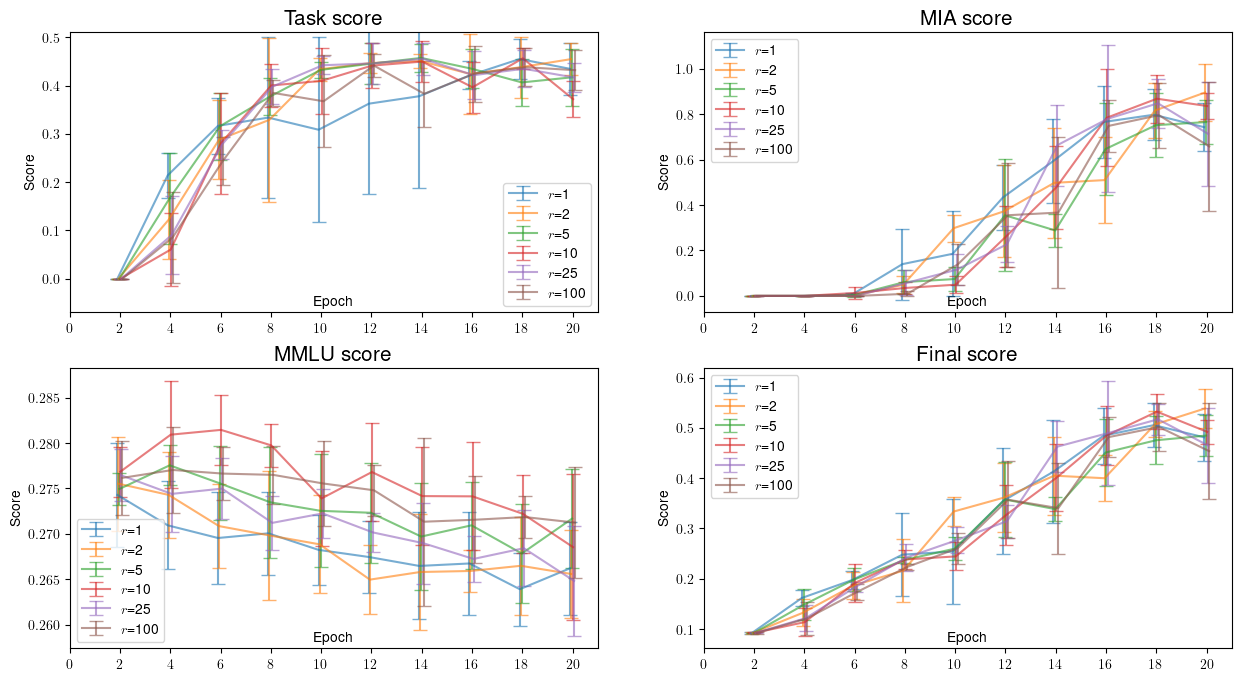

In [29]:
logsdir = "experiment_logs/1B_rank_logs"
data = extract_data(logsdir)
scores, checkpoints = collect_scores(data, params=["lr", "la"])

print(scores)

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

fig, axs = plt.subplots(2, 2, figsize=(15, 8))


points = [
    (i, f"checkpoint_{i-1}") for i in range(2, 21, 2)
]
measures = ["harmonic", "mia", "mmlu", "aggregate"]
titles = ["Task score", "MIA score", "MMLU score", "Final score"]
idx = [(0, 0), (0, 1), (1, 0), (1, 1)]
linewidth = 1.5

offset=0.2
last=len(scores)-1

for i, m in enumerate(measures):
    handles = []
    for j, p in enumerate(sorted(scores, key=lambda x: int(x[0]))):
        means = []
        stds = []
        for point in points:
            mean = np.mean(scores[p][point[1]][m])
            std = np.std(scores[p][point[1]][m])
            means.append(mean)
            stds.append(std)
        axs[idx[i]].errorbar(
            [x[0] + offset * (j / last - 0.5)  for x in points],
            list(means),
            yerr=list(stds),
            label=f"$r$={p[0]}",
            linewidth=linewidth,
            capsize=5,
            alpha=0.6,
        )
        
    axs[idx[i]].set_title(titles[i], fontsize=15)
    axs[idx[i]].set_xticks([0] + [x[0] for x in points])
    axs[idx[i]].set_xlabel("Epoch")
    axs[idx[i]].xaxis.set_label_coords(0.5, 0.06)
    axs[idx[i]].set_ylabel("Score")
    axs[idx[i]].legend()

axs[(0, 0)].set_ylim(-0.07, 0.51)
plt.savefig("rank_scores.pdf", format="pdf", bbox_inches="tight")
plt.show()